<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [14]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [15]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

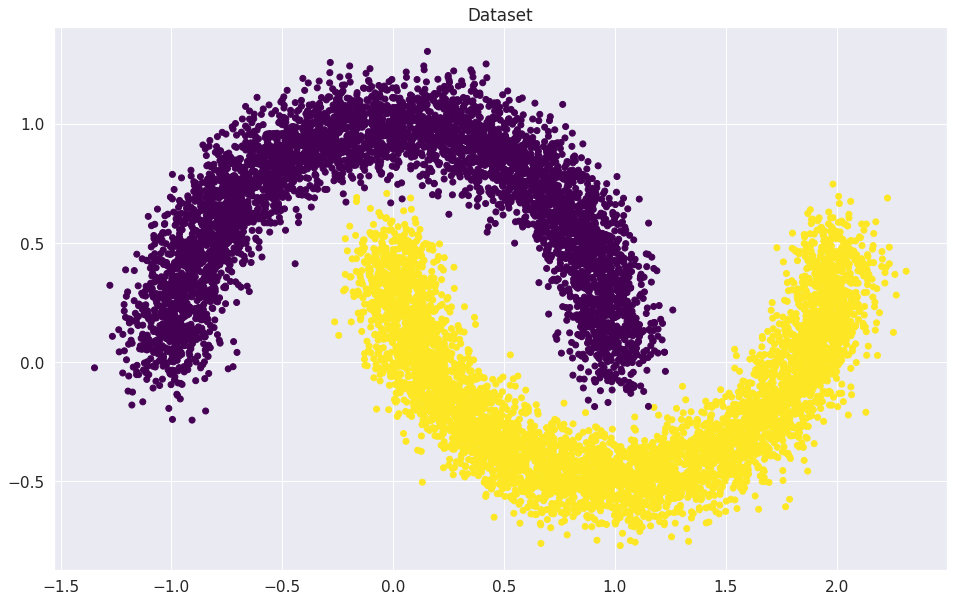

In [16]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [20]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t =  torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t =  torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t =  torch.tensor(y_val, dtype=torch.float32).to(device)

Создаем `Dataset` и `DataLoader`. 

In [21]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспомним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [22]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights.T
        if self.bias:
            x += self.bias_term
        return x

In [30]:
linear_regression = LinearRegression(2, 1).to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [24]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torchinfo

torchinfo.summary(linear_regression, input_size=(1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Итого у нас есть 3 обучаемых параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [31]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.flatten(), y_batch)
        loss.backward()
        losses.append(loss.cpu().detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3125
Iteration: 100
Batch accuracy: 0.6328125
Iteration: 200
Batch accuracy: 0.734375
Iteration: 300
Batch accuracy: 0.75
Iteration: 400
Batch accuracy: 0.78125
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.84375
Iteration: 700
Batch accuracy: 0.8359375

Iteration: 711.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**
711

### Визуализируем результаты

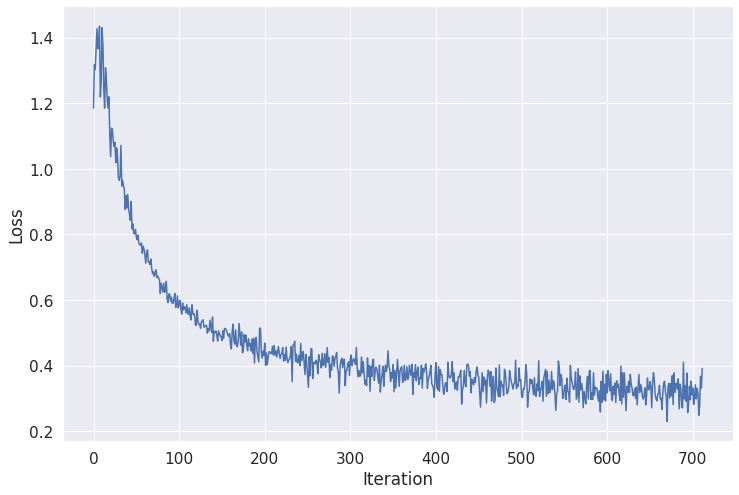

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

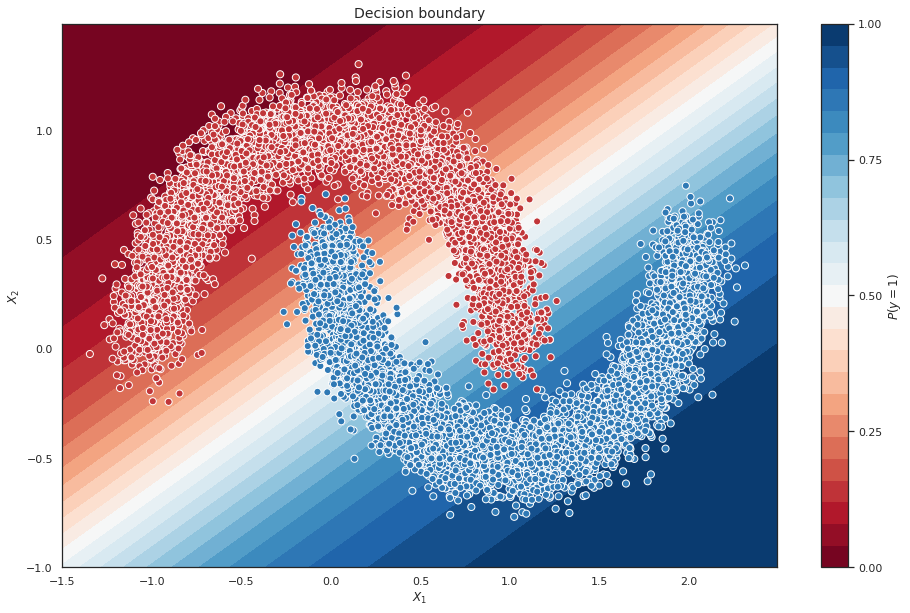

In [35]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32).to(device)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.cpu().numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [38]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model.forward(x_batch)
        probabilities =  torch.sigmoid(preds)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.cpu().numpy().flatten()))
    return predictions.flatten()

In [40]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t.cpu(), y_pred)

0.854

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

0.854

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [48]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=128, shuffle=False)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [49]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [50]:
input_dim = train_dataset[0][0].flatten().size()[0]
print(input_dim)

784


In [51]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_dim, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [54]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).type(torch.long).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.88855
Loader: valid. Accuracy: 0.9419
Epoch: 2
Loader: train. Accuracy: 0.9486
Loader: valid. Accuracy: 0.9594
Epoch: 3
Loader: train. Accuracy: 0.9627
Loader: valid. Accuracy: 0.9646
Epoch: 4
Loader: train. Accuracy: 0.9710833333333333
Loader: valid. Accuracy: 0.9721
Epoch: 5
Loader: train. Accuracy: 0.9758333333333333
Loader: valid. Accuracy: 0.9709
Epoch: 6
Loader: train. Accuracy: 0.9794666666666667
Loader: valid. Accuracy: 0.9744
Epoch: 7
Loader: train. Accuracy: 0.9820833333333333
Loader: valid. Accuracy: 0.9688
Epoch: 8
Loader: train. Accuracy: 0.9840166666666667
Loader: valid. Accuracy: 0.9768
Epoch: 9
Loader: train. Accuracy: 0.9848333333333333
Loader: valid. Accuracy: 0.9755
Epoch: 10
Loader: train. Accuracy: 0.9868833333333333
Loader: valid. Accuracy: 0.9792


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [55]:
elu_accuracy = accuracy["valid"]

In [59]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_dim, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).type(torch.long).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
      
    return accuracy['valid']

In [60]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8724666666666666
Loader: valid. Accuracy: 0.9109
Epoch: 2
Loader: train. Accuracy: 0.90305
Loader: valid. Accuracy: 0.9027
Epoch: 3
Loader: train. Accuracy: 0.9061333333333333
Loader: valid. Accuracy: 0.9119
Epoch: 4
Loader: train. Accuracy: 0.9097
Loader: valid. Accuracy: 0.9126
Epoch: 5
Loader: train. Accuracy: 0.91105
Loader: valid. Accuracy: 0.9139
Epoch: 6
Loader: train. Accuracy: 0.9127166666666666
Loader: valid. Accuracy: 0.9151
Epoch: 7
Loader: train. Accuracy: 0.91385
Loader: valid. Accuracy: 0.9176
Epoch: 8
Loader: train. Accuracy: 0.9150666666666667
Loader: valid. Accuracy: 0.9167
Epoch: 9
Loader: train. Accuracy: 0.9157666666666666
Loader: valid. Accuracy: 0.914
Epoch: 10
Loader: train. Accuracy: 0.91455
Loader: valid. Accuracy: 0.9128
Epoch: 1
Loader: train. Accuracy: 0.8728166666666667
Loader: valid. Accuracy: 0.9324
Epoch: 2
Loader: train. Accuracy: 0.9369666666666666
Loader: valid. Accuracy: 0.9522
Epoch: 3
Loader: train. Accuracy: 0.

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

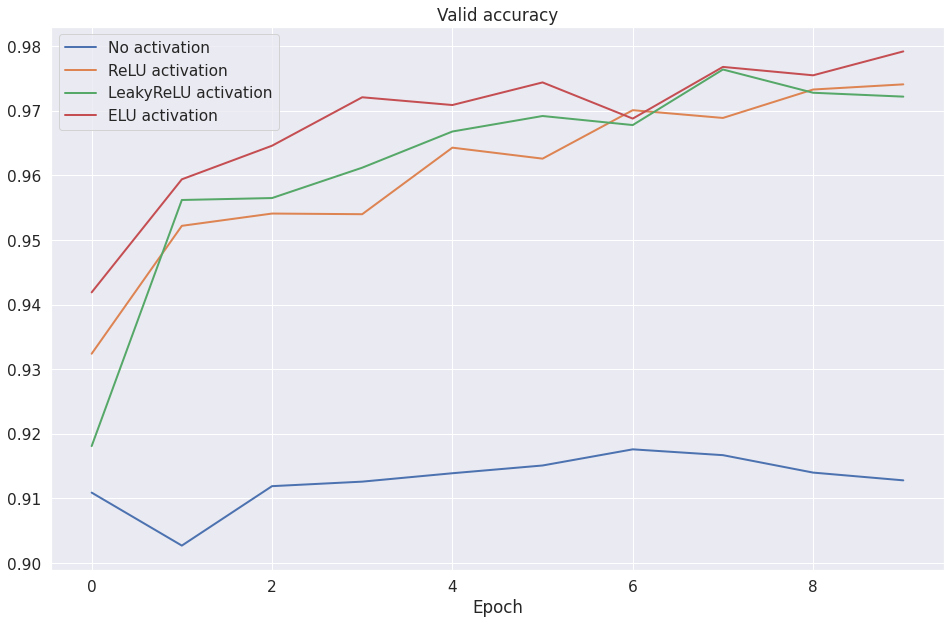

In [61]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

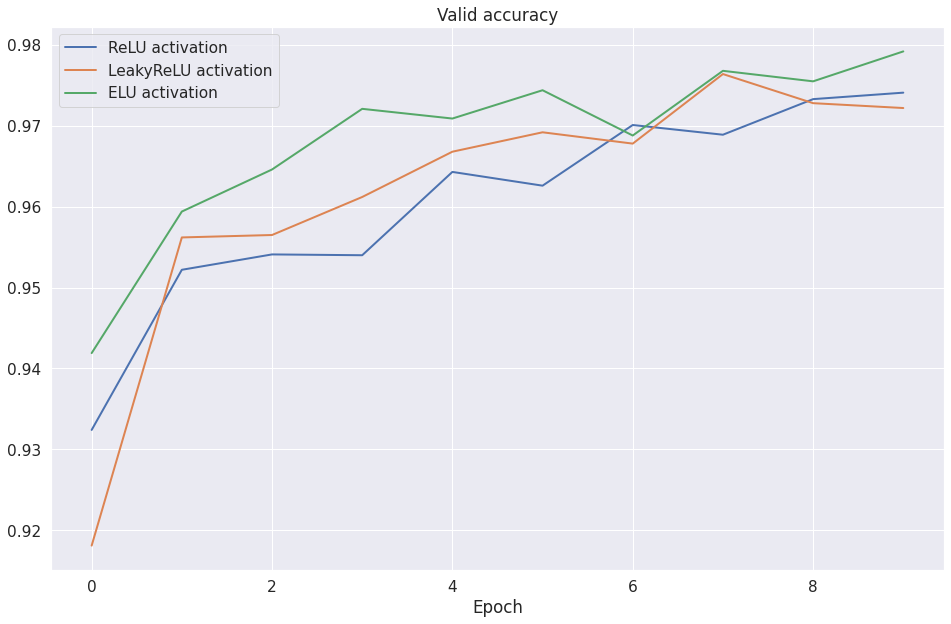

In [62]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**
ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [63]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-11-02 08:38:10--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-11-02 08:38:11--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   164KB/s    in 0.3s    

2022-11-02 08:38:12 (164 KB/s) - ‘sample_photo.jpg’ saved [49337/4

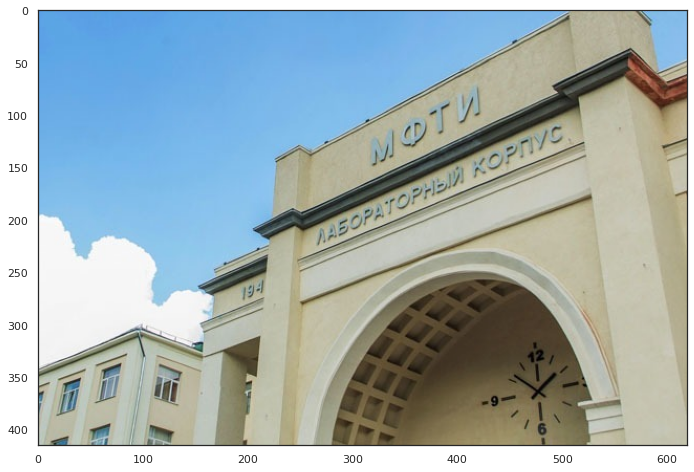

In [64]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [65]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

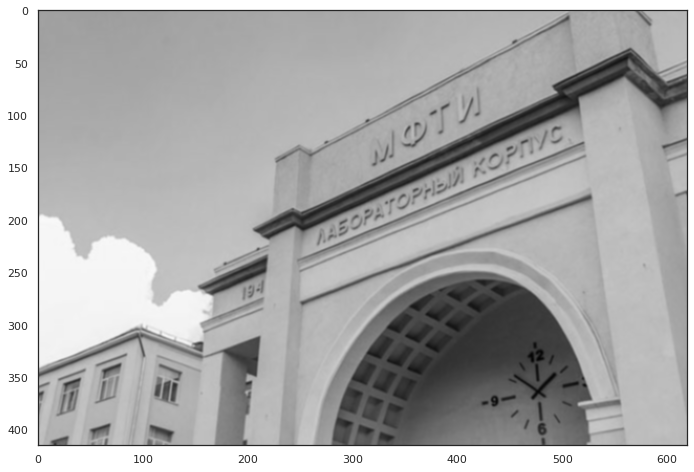

In [66]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

1) Е

2) Д

3) А

4) В

5) Б

6) Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [93]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120) 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [94]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [96]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
model.to(device)
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).type(torch.long).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.88475
Loader: valid. Accuracy: 0.9659
Epoch: 2
Loader: train. Accuracy: 0.9707666666666667
Loader: valid. Accuracy: 0.9769
Epoch: 3
Loader: train. Accuracy: 0.97895
Loader: valid. Accuracy: 0.9796
Epoch: 4
Loader: train. Accuracy: 0.9831
Loader: valid. Accuracy: 0.981
Epoch: 5
Loader: train. Accuracy: 0.9863333333333333
Loader: valid. Accuracy: 0.9857
Epoch: 6
Loader: train. Accuracy: 0.9882666666666666
Loader: valid. Accuracy: 0.9857
Epoch: 7
Loader: train. Accuracy: 0.9894333333333334
Loader: valid. Accuracy: 0.9879
Epoch: 8
Loader: train. Accuracy: 0.9909666666666667
Loader: valid. Accuracy: 0.9866
Epoch: 9
Loader: train. Accuracy: 0.9915166666666667
Loader: valid. Accuracy: 0.9878
Epoch: 10
Loader: train. Accuracy: 0.99305
Loader: valid. Accuracy: 0.9885


In [85]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

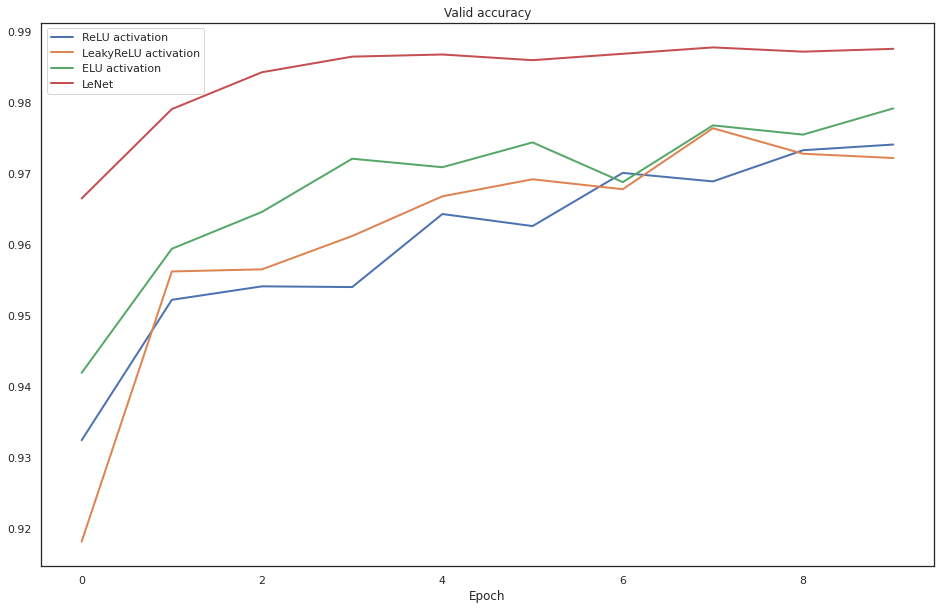

In [86]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**
0,99